# Data from the web

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import unicodedata
import re
from bs4 import BeautifulSoup

In [2]:
initial_url = "http://isa.epfl.ch/imoniteur_ISAP/%21gedpublicreports.htm?ww_i_reportmodel=133685247"

## Function for extract data from the web

In [3]:
def get_key_and_value(url):
    """ Scrape the key and value
        @param url : initial url
        @return : the values and key
    """  
    # Do first request to get initial parameters  from postman
    r = requests.get(url) 
    soup = BeautifulSoup(r.text, "lxml")
    # Get HTML iframe
    frame_list = soup.find_all('frame')
    addition = frame_list[1].attrs["src"]
    base_url = "http://isa.epfl.ch/imoniteur_ISAP/" + addition

    # Second request to get the filter
    r = requests.get(base_url)
    soup = BeautifulSoup(r.text, "lxml")
    html = soup.contents[0]
    body = html.body
    
    # Get the section
    section_div = body.find_all(["div"])
    section_opt = section_div[1].find_all("option")
    section_input = section_div[1].find_all("input")
    section_select=section_div[1].find_all("select")
    
    # Initialize the variable
    period_academ = []
    period_pedago_bachelor = []
    period_pedago_master = []
    period_pedago_projet = []
    hiverete= []
    informatique_value = 0
    real_keys = []
    real_key_value = [] 
    
    # Get the keys and the values
    for elem in section_input:
        if elem["value"]:
            real_keys.append(elem["name"])
            real_key_value.append(elem["value"])
        elif elem["name"].startswith('z'):
            continue
            
    # Scraping for each attribute
    for elem in section_opt:
        for label in elem:
            elem_value = int(elem["value"])
            if label[0].startswith('2'):
                period_academ.append(elem_value)
            elif "Bachelor" in label:
                period_pedago_bachelor.append(elem_value)
            elif "Master semestre" in label:
                period_pedago_master.append(elem_value)
            elif "Projet Master" in label:
                period_pedago_projet.append(elem_value)
            elif "d'automne" in label or "de printemps" in label :
                hiverete.append(elem_value)
            elif "Informatique" in label:
                informatique_value = elem_value
            else:
                continue
    
    # Bachelor semester 1 and 6
    period_pedago_bachelor=[period_pedago_bachelor[0], period_pedago_bachelor[6]]
    # Master semester 1, and 3
    period_pedago_master=[period_pedago_master[0], period_pedago_master[1], period_pedago_master[2]]
    
    for elem in section_select:
        if elem['name']:
            real_keys.append(elem['name'])
            
    real_key_value.append(informatique_value)
    real_key_value.append(period_academ[::-1])
    real_key_value.append(period_pedago_bachelor)
    real_key_value.append(hiverete)
    real_key_value.append(period_pedago_master)
    real_key_value.append(period_pedago_projet)
            
    return real_keys, real_key_value, base_url
    
key,value_key,base_url=get_key_and_value(initial_url)
    

In [4]:
def dic_param(key,value_key,period,semester,section = None):
    """ Compute a dictionnary of parameters
        @param  key : key return with get_key_and_value() function
        @param value_key : value return with get_key_and_value() function
        @param period : academic year
        @param semester : semester
        @param section : choose a section to extract
        @return : a dictionnary containing the parameters for the specific request
    """       
    
    # Retrieve data per section
    if section == "master":
        list_periode_pedago = value_key[9]
        assert 0<=semester<len(list_periode_pedago), \
        'semester={} is wrong: it has to be 0,1 or 2'.format(semester)   
    elif section == "projet":
        list_periode_pedago = value_key[10]
        assert 0<=semester<len(list_periode_pedago), \
        'semester={} is wrong: it has to be 0 or 1'.format(semester) 
    else: # bachelor case
        list_periode_pedago = value_key[7]
        assert 0<=semester<len(list_periode_pedago), \
        'semester={} is wrong: it has to be 0 or 1'.format(semester) 
        
    if semester % 2 == 0:
        season=0
    else:
        season=1
        
    'season={} and semester={} are not compatible, season=0 corresponds to autumn, season = 1 corresponds to springer'.format(season,semester)
    
    list_periode_acad = value_key[6]
    

    assert 0<=period<len(list_periode_acad), \
    'period={} is wrong: it has to be between 0 and {}'.format(period, len(list_periode_acad)-1) 
    
    list_hiverete = value_key[8]
    
    # Dictionary parameters 
    dic_param = {
                key[0]:value_key[0],
                key[1]:value_key[1],
                key[2]:value_key[2],
                key[4]:value_key[4],
                key[5]:value_key[5],
                key[6]:list_periode_acad[period],
                key[7]:list_periode_pedago[semester],# Value (S1 or S6)
                key[8]:list_hiverete[season]# Value (Automne or printemps)
                }
    return dic_param

In [5]:
def extract_web_content(base_url, dict_param):
    """Extract the data from IS-ACADEMIA
       @param url:  principal link get with postman
       @param dict_param: the dictionnary where the key_value represents each field desired
       @return : a dataframe with data requested on dict_param
    """
    url = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.bhtml?'
    # Request for GPS value
    r=requests.get(base_url, params = dict_param)
    soup = BeautifulSoup(r.text,'lxml')
    # Extract GPS name & value
    section_a = soup.find_all("a")
    for elem in section_a:
        section_onclick = elem['onclick']
        GPS_name = elem['class'][0]
    GPS_value = re.findall(r'\d+', section_onclick)[0]
    # Update parameters
    dict_param.update({GPS_name: GPS_value})
    # Request with all parameters
    r=requests.get(url, params = dict_param)
    soup = BeautifulSoup(r.text,'lxml')

    table_data = soup.find('table') # Extract the table part of the html
    try:
        header_tag = table_data.find_all('tr')[1] # Get the second tr
    except:
        return 0
    header = [ele.string for ele in header_tag.contents]


    list_data = []
    for row in table_data.find_all('tr'):
        cols = row.find_all('td')
        try: # Try loop to be robust when the cols=[]
            row_data = [ele.string for ele in cols]
            row_data=row_data[0:11] # last column useless
            list_data.append(row_data)
        except:
            continue
    list_data = [ele for ele in list_data if ele] # To skip the [] value
    df_1 = pd.DataFrame(list_data, columns=header)
    return df_1

# Example 

In order to get data for the bachelor students of the first semester of 2007-2008, we used the **dic_param** function to generate the dictionary of different parameters required to make the get request to the server, then **extract_web_content** function to return the extract data in a dataframe.

In [6]:
dic=dic_param(key,value_key,period=0,semester=0, section="bachelor")
print dic
extract_web_content(base_url,dic).head()

{'ww_i_reportModelXsl': '133685270', 'dummy': 'ok', 'ww_x_PERIODE_ACAD': 978181, 'ww_x_UNITE_ACAD': 249847, 'ww_b_list': '1', 'ww_x_HIVERETE': 2936286, 'ww_x_PERIODE_PEDAGO': 249108, 'ww_i_reportmodel': '133685247'}


,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,No Sciper
0,Monsieur,Arévalo Christian,None,None,None,None,None,Présent,None,None,169569
1,Monsieur,Aubelle Flavien,None,None,None,None,None,Présent,None,None,174905
2,Monsieur,Badoud Morgan,None,None,None,None,None,Présent,None,None,173922
3,Monsieur,Baeriswyl Jonathan,None,None,None,None,None,Présent,None,None,179406
4,Monsieur,Barroco Michael,None,None,None,None,None,Présent,None,None,179428


# Question 1

>Obtain all the data for the Bachelor students, starting from 2007. Keep only the students for which you have an entry for both `Bachelor
semestre 1` and `Bachelor semestre 6`. Compute how many months it took each student to go from the first to the sixth semester. Partition
the data between male and female students, and compute the average -- is the difference in average statistically significant?

## EXTRACTING CONTENT
We used postman to identify the key and value parameters that we needed to send to the server as a get request
We automated the process by creating a **dic_param** function to generate the parameters that we needed. This became the import for the get request to retrieve the corresponding parameters.

We isolated the columns [Civility, Nom Prenom and Sciper No] needed for data analysis.
We placed the bachelor data from all the years and semesters into a dataframe with a hierarchical index containing the academic year, semester and the afformentioned information in the columns.

From this we kept the students that were classed as "present" and on an "exchange programme"

In [7]:
# Extract all bachelor data (all years and semester 1 and 6)
data = pd.DataFrame()
for y in range(10): # All years
    for s in range(2): # Semester 1 and 6
        # Extract information :
        temp_param = dic_param(key,value_key,period=y,semester=s,section="bachelor")
        temp_df = extract_web_content(base_url, temp_param)
        # Process index :
        periode_acad = ['2007-2008','2008-2009','2009-2010','2010-2011','2011-2012','2012-2013','2013-2014','2014-2015','2015-2016','2016-2017']
        semester = ['1', '6']
        arrays = [pd.Series(periode_acad[y] for _ in range(3)),pd.Series(semester[s] for _ in range(3)), [temp_df.columns[0],temp_df.columns[1],temp_df.columns[10]]]
        index = pd.MultiIndex.from_tuples(list(zip(*arrays)), names=['Année', 'Semestre', 'Information'])
        # Process data with Present status and exchange student
        temp_df = pd.concat([temp_df[temp_df['Type Echange'].notnull()],temp_df[temp_df['Statut']== u'Pr\xe9sent']])
        temp_df.drop(temp_df.columns[2:10], axis=1, inplace=True)
        temp_df.columns = index
        data = pd.concat([data, temp_df], axis=1)

In [8]:
data.head()

Année      2007-2008                                          \
Semestre            1                                       6   
Information  Civilité          Nom Prénom No Sciper  Civilité   
0            Monsieur   Arévalo Christian    169569  Monsieur   
1            Monsieur     Aubelle Flavien    174905  Monsieur   
2            Monsieur       Badoud Morgan    173922  Monsieur   
3            Monsieur  Baeriswyl Jonathan    179406  Monsieur   
4            Monsieur     Barroco Michael    179428  Monsieur   

Année                                                     2008-2009  \
Semestre                                                           1   
Information                           Nom Prénom No Sciper  Civilité   
0                                 Barras Florian    170220  Monsieur   
1                                 Beuret Thibaut    166701  Monsieur   
2            Biollay Jean Isaac Jamal Pachacutec    161279  Monsieur   
3                                 Blatter Jérémy    166344  Monsieur   
4                               Boksanyi Michael    161634  Monsieur   

Année                                                      ...    2015-2016  \
Semestre                                               6    ...            1   
Information               Nom Prénom No Sciper  Civilité    ...    No Sciper   
0                    Ahluwalia Samit    184228  Monsieur    ...       235688   
1                         Amiet Nils    179383  Monsieur    ...       249344   
2              Andenmatten Alexandre    186836  Monsieur    ...       246443   
3                      Arnfred Jonas    184772  Monsieur    ...       259105   
4            Badila Constantin-Tudor    187235  Monsieur    ...       262227   

Année                                                             2016-2017  \
Semestre            6                                                      1   
Information  Civilité                         Nom Prénom No Sciper  Civilité   
0                 NaN                                NaN       NaN  Monsieur   
1            Monsieur          Alfonso Peterssen Alfonso    228219  Monsieur   
2            Monsieur           Alonso Seisdedos Florian    215576    Madame   
3            Monsieur  Angerand Grégoire Georges Jacques    212464  Monsieur   
4            Monsieur      Anongba Varela Dario Abougnan    226371  Monsieur   

Année                                                                      \
Semestre                                       6                             
Information       Nom Prénom No Sciper  Civilité                Nom Prénom   
0            Abbey Alexandre    235688  Monsieur        Abate Bryan Jeremy   
1                Ahn Seongho    274015  Monsieur         Alami-Idrissi Ali   
2              Alemanno Sara    268410  Monsieur             Aoun Leonardo   
3               Althaus Luca    271464  Monsieur  Bachmann Roman Christian   
4                 Assi Karim    274518  Monsieur      Beck Johannes Magnus   

Année                 
Semestre               
Information No Sciper  
0              246671  
1              251759  
2              249498  
3              234551  
4              247328  

[5 rows x 60 columns]

## COMPUTING THE RESULT

We merged the data for all the years from semester1 to semester 6. If a person repeated a semester inbetween semester 1 and 6, it doesn't affect the result as these semesters have been discarded. However, if the person repeats semester 6, we would drop the duplicated semester 6 entry and keep the final repetition year of semester 6 as the final year. 
Year spent = semester 6 academic year - semester 1 academic year 
This is represented in the final dataframe under the "Year spent" column.

In [9]:
results = pd.DataFrame()
for year in range(len(periode_acad)):
    for academic_year in range(len(periode_acad)):
        if academic_year == year:
            continue
        tmp = pd.merge(data[periode_acad[year], semester[0]], data[periode_acad[academic_year],semester[1]])
        tmp.dropna(axis=0, how='all', inplace=True)
        tmp['Year spent'] = academic_year-year+1
        results = pd.concat([results, tmp])
        results.drop_duplicates(subset=results.columns[2], keep='last', inplace=True)

In [10]:
results.sort_values([results.columns[3]], axis=0, inplace=True)
results.head()

Information,Civilité,Nom Prénom,No Sciper,Year spent
0,Monsieur,Arévalo Christian,169569,3
31,Monsieur,Guggenheim Daniel Vincent,224356,3
28,Monsieur,Girod Matthieu,226826,3
25,Monsieur,Gaudet-Blavignac Christophe Edmond Romain,224410,3
24,Monsieur,Gargasson Loïc Yann,223596,3


## CLASSIFICATION OF COMPLETION RATE BASED ON GENDER

We computed the average time spent on a gender basis and created a figure below which highlights the percentage of females and males that graduated for bachelors from 2007-2017

Civilité
Madame       29
Monsieur    367
dtype: int64


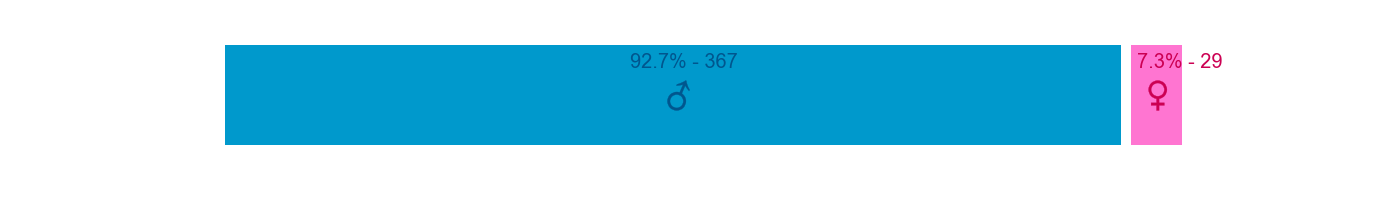

In [11]:
results_grouped = results.groupby(results[results.columns[0]])
print results_grouped.size()
nb_female = results_grouped.size()[0]
nb_male = results_grouped.size()[1]
results_grouped = (results_grouped.size()/results.shape[0])*100
perc_female = results_grouped[0]
perc_male = results_grouped[1]

# Plot Gender
plt.figure(figsize=(24,3))
ax = plt.gca()
ax.grid(False)
ax.patch.set_visible(False)
plt.axis('off')

plt.plot([0, 1+perc_male], [5, 5], linewidth=100, linestyle="-", c="#0099CC",solid_capstyle="butt")
plt.plot([2+perc_male, perc_male+perc_female], [5, 5],linewidth=100, linestyle="-", c='#FF75D1',solid_capstyle="butt")

plt.scatter(1+perc_male/2,5,900,zorder=4,marker=ur'$\u2642$',color='#00568E')
plt.scatter(1+perc_male+perc_female/2,5,900,zorder=4,marker=ur'$\u2640$', color='#CC0052')
plt.annotate(str(round(perc_male,1))+"% - "+str(nb_male), xy=(perc_male/2-4,5.02),size=20,color='#00568E')
plt.annotate(str(round(perc_female,1))+"% - "+str(nb_female), xy=(perc_male+perc_female/2-1,5.02),size=20,color='#CC0052')

## REPARTITION OF YEAR SPENT TO BE GRADUATE

We computed the percentage of people who graduated on a year by year basis and we plot the number of people for each year spent

Year spent
3    75.252525
4    22.474747
5     2.020202
6     0.252525
dtype: float64


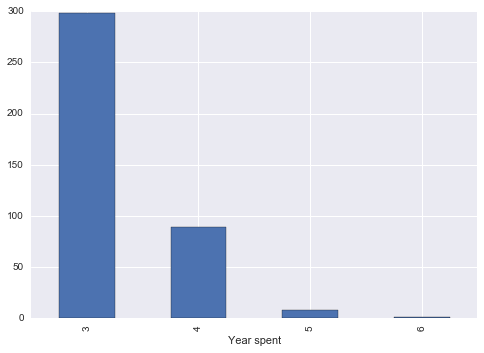

In [12]:
results_grouped = results.groupby(results[results.columns[3]])
print 100*(results_grouped.size()/results.shape[0])
results_grouped.size().plot(kind='bar')

## AVERAGE FOR EACH GENDER

We partition the data by gender and compute the average year spent per gender

In [13]:
Male = results[results[results.columns[0]]=='Monsieur']
Female = results[results[results.columns[0]]=='Madame']
print "Average year spent for male : %lf"%(Male['Year spent'].mean())
print Male.describe()
print "--"*20
print "Average year spent for female : %lf"%(Female['Year spent'].mean())
print Female.describe()

Average year spent for male : 3.280654
Information  Year spent
count        367.000000
mean           3.280654
std            0.512395
min            3.000000
25%            3.000000
50%            3.000000
75%            4.000000
max            6.000000
----------------------------------------
Average year spent for female : 3.172414
Information  Year spent
count         29.000000
mean           3.172414
std            0.384426
min            3.000000
25%            3.000000
50%            3.000000
75%            3.000000
max            4.000000


# Hypothesis testing :

The mean of the two genders are different, additionally the number of samples are unequal. The standard deviation of each groups is different. In order to compare the mean of year spent for each gender, we performed a t-test with the following hypothesis :
>\- H<sub>0</sub> : The mean of year spent is the same for male and female.  
\- H<sub>A</sub> : The mean of year spent is different for male and female.  

We decided to choose the unequal variance t-test due to the unequal number of samples. The t-test is computed with the following formula : 
$$t = \frac{m_A - m_B}{\sqrt{ \frac{S_A^2}{n_A} + \frac{S_B^2}{n_B} }}$$

* _mA_ et _mB_ represents the mean of each group.    
* _nA_ et _nB_ represents the sample size of each group.  
* _SA_ et _SB_ represents the standard deviation of each group.

In [14]:
from scipy import stats
t_test = stats.ttest_ind(Male["Year spent"],Female["Year spent"], equal_var = False)
print "The t-statistic is %.3f and the p-value is %.3f." % t_test

The t-statistic is 1.420 and the p-value is 0.164.


We find a high p-value (16%) compared to the significance level chosen (5%), therefore we accept the alternate hypothesis, the mean of year spent is different for male and female. 

# Question 2

>Perform a similar operation to what described above, this time for Master students. Notice that this data is more tricky, as there are
many missing records in the IS-Academia database. Therefore, try to guess how much time a master student spent at EPFL by at least checking
the distance in months between `Master semestre 1` and `Master semestre 2`. If the `Mineur` field is *not* empty, the student should also
appear registered in `Master semestre 3`. Last but not the least, don't forget to check if the student has an entry also in the `Projet Master`
tables. Once you can handle well this data, compute the "average stay at EPFL" for master students. Now extract all the students with a 
`Spécialisation` and compute the "average stay" per each category of that attribute -- compared to the general average, can you find any
specialization for which the difference in average is statistically significant?

## EXTRACT MASTER STUDENT 

We extract all semesters and semester projects of master student from each year.
We kept only the ones who are exchange students, interns or have present status.  

In [16]:
# Extract all data (all years and semester 1,2 and 3)
data = pd.DataFrame()
for y in range(10): # All years
    for s in range(3): # Semester 1,2,3
        # Extract information :
        temp_param = dic_param(key,value_key,period=y,semester=s,section="master")
        temp_df = extract_web_content(base_url, temp_param)
        # Process index :
        periode_acad = ['2007-2008','2008-2009','2009-2010','2010-2011','2011-2012','2012-2013','2013-2014','2014-2015','2015-2016','2016-2017']
        semester = ['1', '2','3']
        arrays = [pd.Series(periode_acad[y] for _ in range(5)),pd.Series(semester[s] for _ in range(5)), [temp_df.columns[0],temp_df.columns[1],temp_df.columns[4],temp_df.columns[6],temp_df.columns[10]]]
        index = pd.MultiIndex.from_tuples(list(zip(*arrays)), names=['Année', 'Semestre', 'Information'])
        # Process data with Present status
        temp_df = pd.concat([temp_df[temp_df['Type Echange'].notnull()],temp_df[temp_df['Statut']== u'Pr\xe9sent'],temp_df[temp_df['Statut']=='Stage']])
        temp_df.drop(temp_df.iloc[:,[2,3,5,7,8,9]], axis=1, inplace=True)
        temp_df.columns = index
        data = pd.concat([data, temp_df], axis=1)
    for p in range(2): # Project master
        semester_project = ['P1', 'P2']
        # Extract information :
        temp_param = dic_param(key,value_key,period=y,semester=p,section="projet")
        temp_df = extract_web_content(base_url, temp_param)  
        try:
            arrays = [pd.Series(periode_acad[y] for _ in range(5)),pd.Series(semester_project[p] for _ in range(5)), [temp_df.columns[0],temp_df.columns[1],temp_df.columns[4],temp_df.columns[6],temp_df.columns[10]]]
            index = pd.MultiIndex.from_tuples(list(zip(*arrays)), names=['Année', 'Semestre', 'Information'])
            # Process data with Present status
            temp_df = pd.concat([temp_df[temp_df['Type Echange'].notnull()],temp_df[temp_df['Statut']== u'Pr\xe9sent'],temp_df[temp_df['Statut']=='Stage']])
            temp_df.drop(temp_df.iloc[:,[2,3,5,7,8,9]], axis=1, inplace=True)
            temp_df.columns = index
            data = pd.concat([data, temp_df], axis=1)
        except:
            continue

In [17]:
data.head()

Année      2007-2008                                                   \
Semestre            1                                                    
Information  Civilité                 Nom Prénom Spécialisation Mineur   
0            Monsieur  Aeberhard François-Xavier           None   None   
1              Madame              Agarwal Megha           None   None   
2            Monsieur         Anagnostaras David           None   None   
3            Monsieur              Auroux Damien           None   None   
4            Monsieur             Awalebo Joseph           None   None   

Année                                                      \
Semestre                      2                              
Information No Sciper  Civilité                 Nom Prénom   
0              153066  Monsieur  Aeberhard François-Xavier   
1              180027    Madame              Agarwal Megha   
2              152232  Monsieur         Anagnostaras David   
3              177395  Monsieur              Auroux Damien   
4              161970  Monsieur             Awalebo Joseph   

Année                           \
Semestre                          
Information      Spécialisation   
0                          None   
1                          None   
2                          None   
3            Internet computing   
4                          None   

Année                                                                    \
Semestre                                                                   
Information                                             Mineur No Sciper   
0                                                         None    153066   
1                                                         None    180027   
2            Mineur en Management, technologie et entrepren...    152232   
3                                                         None    177395   
4                                                         None    161970   

Année         ...    2016-2017                                               \
Semestre       ...            3                                                
Information    ...     Civilité                                   Nom Prénom   
0              ...       Madame                                Abi Akar Nora   
1              ...       Madame                                  Aeby Prisca   
2              ...     Monsieur                  Alnasser Riyadh Abdulaziz M   
3              ...     Monsieur  Amorim Afonso Caldeira Da Silva Pedro Maria   
4              ...     Monsieur                   Andreina Sébastien Laurent   

Année                                                                \
Semestre                                                          P1   
Information                Spécialisation Mineur No Sciper  Civilité   
0                                    None   None    251253  Monsieur   
1            Internet Information Systems   None    225654  Monsieur   
2                                    None   None    257825  Monsieur   
3                                    None   None    213618  Monsieur   
4               Information Security - SP   None    215623  Monsieur   

Année                                                        \
Semestre                                                       
Information              Nom Prénom           Spécialisation   
0                    Amiguet Jérôme                     None   
1            Antognini Diego Matteo                     None   
2                   Antognini Marco  Foundations of Software   
3                  Bouquet Stéphane                     None   
4                      Bovet Sidney                     None   

Année                                                                    
Semestre                                                                  
Information                                             Mineur No Sciper  
0                                                         None    166075

## COMPUTE THE RESULT
We merged the data for all students from master semester 1 and 2, as the base dataframe. We merged the aforementioned data frame with those of semester 3, project 1 and project 2.
We removed all the student's duplicates so e ach student had 1 entry then add a year spent column, to store the cummulative appearance of the student. We normalize data by adding 6 months as the expected completion time at EPFL is 2 years.

In [18]:
results = pd.DataFrame()
for year in range(len(periode_acad)):
    # Keep only master student on master 1 and 2 on the same year
    temp_m1_m2 = pd.merge(data[periode_acad[year],'1'],data[periode_acad[year],'2'],on=[u'Civilit\xe9',u'Nom Pr\xe9nom','No Sciper'])
    temp_m1_m2.dropna(axis=0, how='all', inplace=True)
    temp_m1_m2.drop(temp_m1_m2.iloc[:,[2,3]], axis=1, inplace=True)
    index = [[data[periode_acad[year],'1'].columns[0],data[periode_acad[year],'1'].columns[1],data[periode_acad[year],'1'].columns[2],data[periode_acad[year],'1'].columns[3],data[periode_acad[year],'1'].columns[4]]]
    temp_m1_m2 = temp_m1_m2.ix[:,[0,1,3,4,2]]
    temp_m1_m2.columns = index
    
    # Comparison with master 3, Project master 1 and 2 of other years
    for academic_year in range(len(periode_acad)):
        if academic_year == year:
            continue
        # Master 3
        temp_m123 = pd.merge(temp_m1_m2, data[periode_acad[academic_year],semester[2]])
        temp_m123.dropna(axis=0, how='all', inplace=True)
        temp_m123['Year spent'] = academic_year-year+1
        results = pd.concat([results, temp_m123])
        results.drop_duplicates(subset=results.columns[1], keep='last', inplace=True)
        # Master project
        for project in range(len(semester_project)):
            try:
                temp_project = pd.merge(temp_m1_m2, data[periode_acad[academic_year],semester_project[project]])
                temp_project.dropna(axis=0, how='all', inplace=True)
                temp_project['Year spent'] = academic_year-year+1
                results = pd.concat([results, temp_project])
                results.drop_duplicates(subset=results.columns[1], keep='last', inplace=True)
            except:
                continue

In [19]:
results.head()

,Civilité,Nom Prénom,Spécialisation,Mineur,No Sciper,Year spent
0,Monsieur,Aeberhard François-Xavier,None,None,153066,2
1,Monsieur,Anagnostaras David,None,"Mineur en Management, technologie et entrepren...",152232,2
2,Monsieur,Auroux Damien,Internet computing,None,177395,2
3,Monsieur,Awalebo Joseph,None,None,161970,2
4,Monsieur,Bayramoglu Ersoy,None,None,178879,2


## Average stay at EPFL for master students

We compute the average stay of master students at EPFL :

In [20]:
results['Year spent'].value_counts()

2    471
3     82
5      1
4      1
Name: Year spent, dtype: int64

In [21]:
master_avr = results['Year spent'].mean()
print 'The average stay for master students is %2.2lf years'%(master_avr)

The average stay for master students is 2.16 years


## Average stay per each specialization

We split data by specialization and compute the average stay on each subparts.

In [22]:
master_spe = results.dropna(subset=[results.columns[2]])
master_spe = master_spe.ix[:,[2,5]]
master_spe_mean = master_spe.groupby(results.columns[2]).mean()
master_spe_mean['Student number'] = master_spe.groupby(results.columns[2]).count()
master_spe_mean

,Year spent,Student number
Spécialisation,,
Computer Engineering - SP,2.333333,15
Computer Science Theory,2.000000,1
Data Analytics,2.000000,3
Foundations of Software,2.306122,49
Information Security - SP,2.166667,6
Internet Information Systems,2.000000,1
Internet computing,2.223881,67
Service science,2.500000,2
"Signals, Images and Interfaces",2.523810,21


## Hypothesis testing :

Do any of the specialization means differ from one another ?  
In order to answer to this issue, we perform a t-test.  
The analysis of variance is a statistical inference test that allows to compare multiple groups at the same time.

>\- H<sub>0</sub> : The mean of year spent is the same for each specialization.  
\- H<sub>A</sub> : The mean of year spent is different for each specialization.  

In [23]:
master_spe = results.dropna(subset=[results.columns[2]])
master_spe = master_spe.ix[:,[2,5]]

master_spe = master_spe.groupby(results.columns[2])
master_grouped = [master_spe.get_group(g)['Year spent'] for g in master_spe.groups]

stats.f_oneway(*master_grouped)

F_onewayResult(statistic=1.0978911493639725, pvalue=0.36689379874507599)

The p-value is high (36%), therefore we can't conclude about the null hypothesis. The average is not statistically significant

## Bonus

>Perform the gender-based study also on the Master students, as explained in 1. Use scatterplots to visually identify changes
over time. Plot males and females with different colors -- can you spot different trends that match the results of your statistical tests?


In [24]:
gender_group_year = results.groupby([results.columns[0], results.columns[5]])
gender_group = gender_group_year.size()

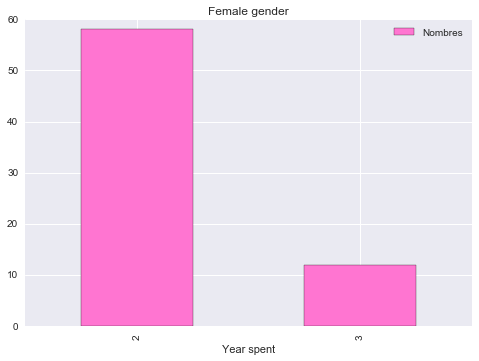

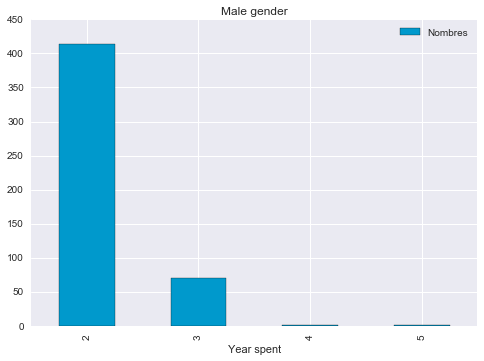

In [25]:
gender = pd.DataFrame(data=gender_group,columns=['Nombres'])
Female = gender.loc['Madame']
Male = gender.loc['Monsieur']
Female.plot(kind='bar',color='#FF75D1')
plt.title('Female gender')
Male.plot(kind='bar',color="#0099CC")
plt.title('Male gender')


In [26]:
Male = results[results[results.columns[0]]=='Monsieur']
Female = results[results[results.columns[0]]=='Madame']
print "Average year spent for male : %lf"%(Male['Year spent'].mean())
print Male.describe()
print "--"*20
print "Average year spent for female : %lf"%(Female['Year spent'].mean())
print Female.describe()

Average year spent for male : 2.154639
       Year spent
count  485.000000
mean     2.154639
std      0.384090
min      2.000000
25%      2.000000
50%      2.000000
75%      2.000000
max      5.000000
----------------------------------------
Average year spent for female : 2.171429
       Year spent
count   70.000000
mean     2.171429
std      0.379604
min      2.000000
25%      2.000000
50%      2.000000
75%      2.000000
max      3.000000
